In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from centroid_classifier import CentroidClassifier


# Centroid Classifier

The `CentroidClassifier` class is an implementation of the [Nearest Centroid Classification Algorithm](https://en.wikipedia.org/wiki/Nearest_centroid_classifier). This classical algorithm [is implemented in Scikit-Learn in the `sklearn.neighbors.NearestCentroid` module](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestCentroid.html), though this module provides several generalizations to this algorithm. 

The interface to this classifier is consistent with `Sklearn` classifiers - so that one can use the many great utilities implemented in `Sklearn` to peform tasks such as hyperparameter tuning and cross validation. 

This document covers how to use the `CentroidClassifier`, and covers a case study using the `ionosphere` dataset, from the UCI machine learning repository. 

---

## Contents

### 1. Nearest Centroid Algorithm
- 1.1 Classical algorithm
- 1.2 Drawbacks of Nearest Centroid classification

### 2. Extensions to classical algorithm
- 2.1 Mahalanobis and skew distances
- 2.2 Reframing one classification problem as another

### 3. Case study - Ionosphere dataset
- 3.1 `iononsphere` dataset
- 3.2 Functionality of `CentroidClassifier` class
- 3.3 Hyperparameter tuning

### 4. Model comparisons
- 4.1 Training Logistic Regression, SVM, and KNN models
- 4.2 Model performance

### 5. Conclusion

---

## 1. Nearest Centroid Algorithm

#### 1.1 Classical algorithm

The Nearest Centroid algorithm is a simple supervised learning algorithm. During training, the mean (centroid) of the training data of each class (label) is calculated. To predict the class of a new vector, the distance between said vector and each of the class centroids is calculated, and vector is assigned to the class whose centroid it is closest.

Those familiar with the `K-Means` unsupervised clustering algorithm may recognize that the prediction step is identical to the label updating step in the `K-Means` algorithm. 


#### 1.2 Drawbacks of Nearest Centroid classification

The Nearest Centroid algorithm is a simple and efficient method. It has no hyperparameters - which makes it a practical baseline classifier. 

The algorithm performs poorly under certain circumstances, however. First - it does not handle non-convex classes well. Secondly, when using Euclidean distance as the distance measure - the algorithm struggles when the classes have  different variances and/or skews, or strong covariances between the features. 

## 2. Extensions to classical algorithm

#### 2.1 Mahalanobis and Skew distances

When using Euclidean distance to a class centroid, the covariance in the data is ignored. Therefore, in the image below, points **1** and **2** are considered to be the same distance away from the origin.  

![](examples/images/euc_contour.png)

However, in light of the rest of the data, it's clear that point **1** deviates from the origin more extremely than **2**, since point **2** falls in the cloud of the rest of the data. Ingoring the covariance in the data leads us to ignore this fact. 

Mahalanobis distance addresses this issue. According to Wikipedia, the Mahalanobis distance "is a multi-dimensional generalization of the idea of measuring how many standard deviations away [a point] is from the mean [of a set of vectors]." One can also think of the Mahalanobis distance as a metric that first transforms the data to remove covariance, then then calculates the Euclidean distance. 

A countour plot of the Mahalanobis distance better reflects the general shape of the data, and captures the intuition of measuring how "unusually far" a point is from the mean more naturally. 

![](examples/images/mah_contour.png)
*Images courtesy of [Vincent Zoonekynd](http://zoonek2.free.fr/UNIX/48_R/06.html)*


In this module, we extend Scikit-Learn's implementation of the Nearest Centroid algorithm by impementing the Mahalanobis distance for classification. We also implemented a novel distance metric - _skew distance_ - which takes into account the skew in the principle components of a datset - as proposed by [Dr. Mark DeBonis](https://manhattan.edu/campus-directory/mark.debonis) in his paper [_"Using Skew for Classification"_](https://www.google.com/search?q=using+skew+for+classification&oq=using+skew+for+classification&aqs=chrome..69i57j69i60j69i61l2j35i39.3895j0j7&sourceid=chrome&ie=UTF-8)


#### 2.2 Reframing one classification problem as another

In the classical Nearest Centroid algorithm, the predicted class of a vector is the class whose centroid is closest to that vector.

We generalize this decision criterion by reframing the original classification task as a seperate auxuilliary classification task. For a data matrix **X** of shape (n, m), and a response vector **y** with `k` unique classes, the classification task is transformed as follows:

1. For each class _c_, compute the centroid of $X_c$, where $X_c \equiv \{X_i  \text{ : }\quad y_i = c\}$
2. For each training example $x \in I\!R^{m}$, construct a vector in $I\!R^k$, $x'$, where the $j^{th}$ component of $x'$ is the distance between $x$ and the $j^{th}$ cluster centroid. Call the collection of these constructed vectors **X'**.  
3. Now we have a design matrix **X'**, of dimension (n, k), and the same vector of labels, **y**. These matrices define the new classification task. 

This setup is a generalization of the classic decision criterion, and allows for the use of arbirary classification methods to be used to solve the constructed classification task (e.g. SVM, Logistic Regression, KNN, etc).

This design choice was to help make this classifier generalizable to a wide variety of datasets, and allow it to learn more complex decision boundaries. 

---

## 3. Case study - Ionosphere dataset

To introduce the interface to the `CentroidClassifier` class and provide a point of reference to its performance, I will apply it to the `ionosphere` dataset from the UCL Machine Learning repository.


#### 3.1 `iononsphere` dataset

The `iononsphere` dataset consists of radar measurements from 16 antenae, and labels that indicate if the measurement is suitable for further analysis not. There are 351 instances and 34 features in the data. 

In [2]:
ion = pd.read_csv("examples/datasets/ionosphere.csv")
ion.head()

,a01,a02,a03,a04,a05,a06,a07,a08,a09,a10,...,a26,a27,a28,a29,a30,a31,a32,a33,a34,class
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,g
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,b
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,g
3,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,b
4,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,g


A natural classification task is to predict if a measurement is good or bad. 

Here I split up the data into training and test splits, for experimentation. 

In [3]:
# isolate design matrix and response vector
X = ion.iloc[:,:-1]
y = ion.iloc[:,-1]

# Make training and test splits for experimentation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [4]:
# sanity check - do dimensions make sense? 
print X.shape, y.shape
print X_train.shape, y_train.shape
print X_test.shape, y_test.shape

(351, 34) (351,)
(280, 34) (280,)
(71, 34) (71,)


#### 3.2 Functionality of `CentroidClassifier` class

The constructor of the `CentroidClassifier` takes to optional parameters:

- `distance`
- `classifier`

The `distance` parameter specifies the distance metric used to compute the distance between a vector and a cluster centroid. The options are:

- `mahalanobis`
- `skew`
- `euclidean`
- `chebyshev`
- `manhattan`

The default value is `mahalanobis`. 

The `classifier` parameter accepts any `Sklearn` classifier object.

In [33]:
# Initialize a nearest-centroid classifier
clf = CentroidClassifier()

The `CentroidClassifier` adopts the same interface as any `sklearn` classifier. As such, it has `fit()` and `predict()` static methods. 

In [34]:
# Fit the classifier on the training data
clf.fit(X_train, y_train)

CentroidClassifier(classifier=None, distance=None)

For binary classification tasks, one can also plot the decision boundary fit using the `plot_boundary()` static method:


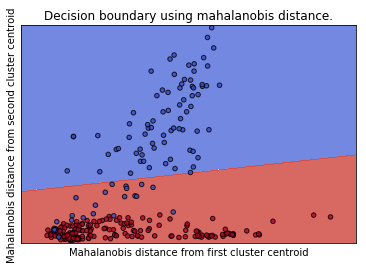

In [35]:
clf.plot_boundary(X_train, y_train)

Comparing this decision boundary to the one learned when using Euclidean distance:

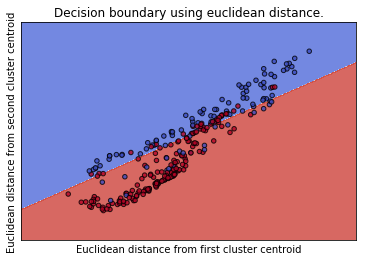

In [8]:
# A classifier that uses Euclidean distance instead of Mahalanobis:
clf_euc = CentroidClassifier(distance="euclidean")

# Fit the model
clf_euc.fit(X_train, y_train)

# plot decision boundary
clf_euc.plot_boundary(X_train, y_train)

We can see that the classifier - when trained using Mahalanobis distance - is more capable of distinguishing between examples of each classes than a classifier trained using Euclidean distance, as it scales out the covariance within each class. 

Since the `CentroidClassifier` has the same interface as all `sklearn` classifiers, we can use the static `score()` method - which is present in all `sklearn` classifiers - to make this difference in performance more concrete:

In [9]:
print "Training accuracy using Mahalanobis distance: %f" % clf.score(X_train, y_train)
print "Training accuracy using Euclidean distance : %f" % clf_euc.score(X_train, y_train)

Training accuracy using Mahalanobis distance: 0.917857
Training accuracy using Euclidean distance : 0.778571


---

Note that in the plots of the decision boundaries above, we can see that the decision boundary is a straight line in the plane.

Recall that as part of the classification prodcedure, `CentroidClassifier` reduces the original classification task to one in `k` dimensions, where `k` is the number of classes. By defualt, it solves this clssification task using an LDA decomposition, which is why the decision boundary is a line (hyperplane in k dimensions). 

We are not restricted to these simple decision boundaries, however. By passing and `sklearn` classifier object to the constructor of `CentroidClassifier`, we can specify any classifier we'd like to perform the final classification stage. 

For example: instead of using LDA for classification, I can use a Logistic Regression classifier:

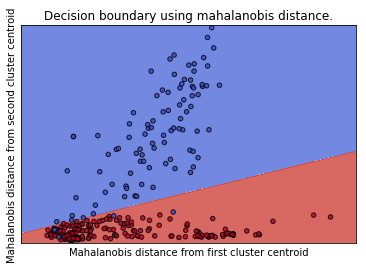

In [10]:
from sklearn.linear_model import LogisticRegression

# initialize a centoid classifier that uses mahalanobis distance, and
# performs logistic regression to carry out the final classification stage.  
clf_logreg = CentroidClassifier(distance="mahalanobis", classifier=LogisticRegression(random_state = 1))

# fit classifier
clf_logreg.fit(X_train, y_train)

# plot decision boundary
clf_logreg.plot_boundary(X_train, y_train)

As expected, the classifier is able to learn more complex functions, and explain more of the variability in the training data:

In [11]:
print "Training accuracy using Logistic Regression classifier : %f" % clf_logreg.score(X_train, y_train)

Training accuracy using Logistic Regression classifier : 0.975000


#### 3.3 Hyperparameter tuning

As always - using more flexible classifiers increases the risk of overfitting our training set. 

Luckily, we can utilize the robust model selection toolit available in `Scikit-Learn` to tune our parameters and perform cross validation. Specifically, I will use the `GridSearchCV` object to search through hyperparameter combinations, and perform 10-fold cross validation to select the hypereparameters that maximize our cross-validation accuracy:

In [12]:
from sklearn.model_selection import GridSearchCV

In [13]:
# create a hyperparameter grid to search through
logreg_grid = {"classifier" : [LogisticRegression(random_state = 1)],
               "C": [.01, .1, .5, 1, 1.5, 3], 
              "tol": [1e-5, 1e-4, 1e-3], 
              "penalty": ['l1', 'l2']}

# initialize a new CentroidClassifier to search through
clf_gs = CentroidClassifier(distance="mahalanobis")

# Initialize a gridsearch CV object, and set up to perform 10-fold CV
gs = GridSearchCV(clf_gs, param_grid = logreg_grid, cv = 10, verbose = 1)


In [14]:
# run grid search
gs.fit(X_train, y_train)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:   10.3s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=CentroidClassifier(classifier=None, distance=None),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 0.5, 1, 1.5, 3], 'classifier': [LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)], 'tol': [1e-05, 0.0001, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [15]:
gs.best_params_

{'C': 0.01,
 'classifier': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 'penalty': 'l1',
 'tol': 1e-05}

In [16]:
clf_gs = CentroidClassifier(distance = "mahalanobis", 
                   classifier = LogisticRegression(C = .01, penalty = "l1", tol = 1e-5, random_state = 1))

In [17]:
clf_gs.fit(X_train, y_train)

CentroidClassifier(classifier=None, distance=None)

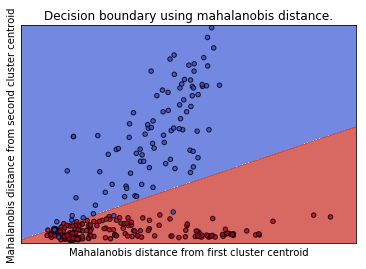

In [18]:
clf_gs.plot_boundary(X_train, y_train)

---

## 4. Model comparisons

Now that we have a tuned and trained Nearest Centroid classifier, we can guage the efficacy of this model by comparing it to more classical methods. 

Here, I'll train Logistic Regression, Support Vector Machine  and KNN classifiers, and tune their respective hyperparameters using a `GridSearchCV`. Then, I'll compare each model's test set prediction accuracy. 

#### 4.1 Training Logistic Regression, SVM, and KNN models


In [19]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

First, training a Logistic regression classifier:

In [20]:
# a logistic regression classifier
logreg = LogisticRegression(random_state=1)

# parameter grid to search through
logreg_grid = {"C": [.01, .1, .5, 1, 1.5, 3], 
              "tol": [1e-5, 1e-4, 1e-3], 
              "penalty": ['l1', 'l2']}

# initialize a gridsearch object to search through Logistic regression hyperparameter combinations
gs_logreg = GridSearchCV(estimator = logreg, param_grid = logreg_grid, cv = 10, verbose = 1)

# Run grid search
gs_logreg.fit(X_train, y_train)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:    3.5s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 0.5, 1, 1.5, 3], 'tol': [1e-05, 0.0001, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [21]:
# isolate the best logistic regression estimator
best_logreg = gs_logreg.best_estimator_

Second, training a Support Vector Machine:

In [22]:
# a support vector machine classifier
svm = SVC(random_state=1)

# parameter grid to search through
svm_grid = {"C" : [.01, .1, .5, 1, 1.5, 3],
            "kernel" : ["rbf", "linear", "sigmoid", "poly"],
           "shrinking" : [True, False]}

# initialize a gridsearch object to search through Logistic regression hyperparameter combinations
gs_svm = GridSearchCV(estimator = svm, param_grid = svm_grid, cv = 10, verbose = 1)

# Run grid search
gs_svm.fit(X_train, y_train)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:    4.6s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=1, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'kernel': ['rbf', 'linear', 'sigmoid', 'poly'], 'C': [0.01, 0.1, 0.5, 1, 1.5, 3], 'shrinking': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [23]:
# isolate the best svm regression estimator
best_svm = gs_svm.best_estimator_

Finally, training a KNN classifier:

In [24]:
# a k-nearest neighbors classifier
knn = KNeighborsClassifier()

# parameter grid to search through
knn_grid = {"n_neighbors" : range(3, 33, 3),
            "weights" : ["uniform", "distance"],
            "p" : [1,2]}
    

# initialize a gridsearch object to search through Logistic regression hyperparameter combinations
gs_knn = GridSearchCV(estimator = knn, param_grid = knn_grid, cv = 10, verbose = 1)

# Run grid search
gs_knn.fit(X_train, y_train)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    4.4s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [3, 6, 9, 12, 15, 18, 21, 24, 27, 30], 'weights': ['uniform', 'distance'], 'p': [1, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [25]:
# isolate best model
best_knn = gs_knn.best_estimator_

---

#### 4.2 Model performance

Now, comparing each classifier's accuracy, precision and recall:

In [26]:
print "CENTROID CLASSIFIER"
print
print"Test set accuracy: %f" % clf_gs.score(X_test, y_test)
print
print(classification_report(y_pred = clf_gs.predict(X_test), y_true = y_test))

CENTROID CLASSIFIER

Test set accuracy: 0.915493

             precision    recall  f1-score   support

          b       0.87      0.93      0.90        28
          g       0.95      0.91      0.93        43

avg / total       0.92      0.92      0.92        71



In [27]:
print "LOGISTIC REGRESSION"
print
print"Test set accuracy: %f" % best_logreg.score(X_test, y_test)
print
print(classification_report(y_pred = best_logreg.predict(X_test), y_true = y_test))

LOGISTIC REGRESSION

Test set accuracy: 0.887324

             precision    recall  f1-score   support

          b       1.00      0.71      0.83        28
          g       0.84      1.00      0.91        43

avg / total       0.90      0.89      0.88        71



In [28]:
print "SUPPORT VECTOR MACHINE"
print
print"Test set accuracy: %f" % best_svm.score(X_test, y_test)
print
print(classification_report(y_pred = best_svm.predict(X_test), y_true = y_test))

SUPPORT VECTOR MACHINE

Test set accuracy: 0.887324

             precision    recall  f1-score   support

          b       1.00      0.71      0.83        28
          g       0.84      1.00      0.91        43

avg / total       0.90      0.89      0.88        71



In [29]:
print "K-NEAREST NEIGHBORS"
print
print"Test set accuracy: %f" % best_knn.score(X_test, y_test)
print
print(classification_report(y_pred = best_knn.predict(X_test), y_true = y_test))

K-NEAREST NEIGHBORS

Test set accuracy: 0.830986

             precision    recall  f1-score   support

          b       1.00      0.57      0.73        28
          g       0.78      1.00      0.88        43

avg / total       0.87      0.83      0.82        71



---

In summary: 

|                    | Logistic Regression | Support Vector Machine | K-Nearest Neighbors | Centroid Classifier (Mahalanobis + Logistic Regression) |
|--------------------|---------------------|------------------------|---------------------|---------------------------------------------------------|
| Test Set Accuracy  | 88.7%               | 88.7%                  | 83%                 | *91.5% *                                                  |
| Test Set Precision | 90%                 | 90%                    | 87%                 | *92%*                                                     |
| Test Set Recall    | 89%                 | 89%                    | 83%                 | *92%*                                                     |
| Test Set F1        | 88%                 | 88%                    | 82%                 | *92%*                                                    |

---

## 5. Conclusion

TODO